## Time Series-Sentiment forecasting

### Import libraries

In [ ]:

import numpy as np
import pandas as pd
import gzip                            # to extract file from zip file
import json  

#decompose
from statsmodels.tsa.seasonal import seasonal_decompose

# dickey fuller test for stationarity
from statsmodels.tsa.stattools import acf,pacf,adfuller

# ARIMA
from statsmodels.tsa.arima.model import ARIMA

# plots
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error

# Ljung-Box test for model goodness
import statsmodels.api as sm
# resampling
from sklearn.utils import resample

import warnings
warnings.filterwarnings("ignore")

### Importing data set

In [ ]:
office_sent = pd.read_csv("C:/Users/sandp/Downloads/office_data_final.csv")

In [ ]:
office_sent.head(2)

,ratings,verified,date,reviewerID,asin,review,summary,unixReviewTime,category,description,...,Sentiment,word_count,char_count,avg_word,polarity,label,year,rating_class_num,review_length,review_length_bin
0,4.0,True,2017-11-07,A2NIJTYWADLK57,0140503528,kids like story really wanted board book one s...,"good story, small size book though",1510012800,"['Office Products', 'Office & School Supplies'...",['Corduroy the bear goes to the launderette wi...,...,Positive,11,62,4.7,-0.016667,1.0,2017,1,11,"(0, 100]"
1,4.0,True,2017-03-07,A2827D8EEURMP4,0140503528,bought used came great condition almost like n...,Good,1488844800,"['Office Products', 'Office & School Supplies'...",['Corduroy the bear goes to the launderette wi...,...,Positive,20,135,5.8,0.625000,1.0,2017,1,20,"(0, 100]"


In [ ]:
#Extracting month from date
office_sent['date']=pd.to_datetime(office_sent['date'])
office_sent['Month'] = office_sent['date'].dt.month 

In [ ]:
# Resampling
office_pos = office_sent[office_sent['Sentiment']=='Positive']
office_neu = office_sent[office_sent['Sentiment']=='Neutral']
office_neg = office_sent[office_sent['Sentiment']=='Negative']
 

df_office_pos = resample(office_pos, 
                                 replace=False,    
                                 n_samples=35000)

df_office_neu = resample(office_neu, 
                                 replace=True,     
                                 n_samples=35000)

df_office_neg = resample(office_neg, 
                        replace=True, n_samples=35000)



In [ ]:
df_office_pos.head()

,ratings,verified,date,reviewerID,asin,review,summary,unixReviewTime,category,description,...,word_count,char_count,avg_word,polarity,label,year,rating_class_num,review_length,review_length_bin,Month
160925,5.0,True,2017-05-15,A3SXRYRS188QZ3,B000XAORTC,really nice lettering calligraphy pen took min...,Really nice lettering. I do calligraphy,1494806400,"['Office Products', 'Office & School Supplies'...","[""Flexible brush tip and fine tip in one marke...",...,18,115,5.4,0.175000,1.0,2017,1,18,"(0, 100]",5
549111,5.0,False,2016-03-07,AIN73XQ0LYBTF,B00GX1W3KA,color pencils pens colors light erase easily,Great!,1457308800,"['Office Products', 'Office & School Supplies'...","['Like the popular Pilot FriXion pens, these F...",...,7,44,5.4,0.416667,1.0,2016,1,7,"(0, 100]",3
116288,5.0,True,2014-01-11,A2GYV87WW0DMSN,B000E7AIA6,several desk using years jumbo size hold large...,Excellent Value,1389398400,"['Office Products', 'Office & School Supplies'...","[""Extra capacity and added heiight easily hold...",...,37,237,5.4,0.201265,1.0,2014,1,37,"(0, 100]",1
462742,5.0,True,2016-10-19,A2ABP506X7KEW0,B00YDG4ND2,amazing deal best multifunction printer ever b...,"Amazing deal, the best multi-function printer ...",1476835200,"['Office Products', 'Office Electronics', 'Pri...","['A complete multifunction printer for easy, e...",...,12,84,6.1,0.550000,1.0,2016,1,12,"(0, 100]",10
109385,5.0,True,2016-01-29,A2PJCHN6IGG9DR,B000ANLD1M,described great packages,Great,1454025600,"['Office Products', 'Office &amp; School Suppl...","[""Not your basic label. UltraHold permanent ad...",...,3,24,7.3,0.800000,1.0,2016,1,3,"(0, 100]",1


### Taking month wise count of sentiment for products

In [ ]:
office_pos_count=df_office_pos.groupby(['asin','Month','Sentiment']).size().reset_index(name='sentiment_count')
office_pos_count

,asin,Month,Sentiment,sentiment_count
0,0140503528,8,Positive,1
1,0310432065,8,Positive,1
2,0310520347,7,Positive,1
3,0310520347,10,Positive,1
4,0310520347,11,Positive,1
...,...,...,...,...
27686,B01HGD8OYM,7,Positive,1
27687,B01HH3964I,11,Positive,1
27688,B01HH8E2QA,7,Positive,1
27689,B01HHLLLIO,11,Positive,1


In [ ]:
office_pos=pd.merge(df_office_pos,office_pos_count)

### Time series analysis

In [ ]:
office_pos=office_pos[['date','sentiment_count']]
office_pos=office_pos.set_index('date')
office_pos=office_pos.sort_values(by=['date'])
office_pos

,sentiment_count
date,
2000-03-21,1
2000-04-07,1
2000-08-19,1
2000-09-18,1
2000-12-06,1
...,...
2018-09-18,1
2018-09-21,3
2018-09-24,1


### Resampling monthwise

In [ ]:
office_pos=office_pos.resample('M').mean()
office_pos.head()

,sentiment_count
date,
2000-03-31,1.0
2000-04-30,1.0
2000-05-31,NaN
2000-06-30,NaN
2000-07-31,NaN


In [ ]:
office_pos.tail()

,sentiment_count
date,
2018-05-31,1.454545
2018-06-30,1.272189
2018-07-31,1.286822
2018-08-31,1.243243
2018-09-30,1.391304


In [ ]:
office_pos.isnull().sum()

sentiment_count    26
dtype: int64

In [ ]:
office_pos.dropna(inplace=True)

### Defining functions for time series analysis

In [ ]:
# stationarity check
def checkStationarity(data):
    pvalue = adfuller(data)[1]
    print('pvalue:',pvalue)

    if pvalue < 0.05:
        msg = "Data is Stationary. Proceed to model building"
    else:
        msg = " Data is not Stationary. Make the data stationary before model building"

    return msg

# Decomposition
def tsa_comp(df):
    decomp = seasonal_decompose(df, period=12, model='additive')
    d_trend = decomp.trend
    d_seasonal = decomp.seasonal
    d_resid = decomp.resid
    
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(15,8), facecolor='linen')
    plt.xlabel('date')
    plt.ylabel('count of sentiment')
    plt.suptitle('TIME SERIES COMPONENT ANALYSIS', fontweight='bold', size=20)
    ax1.plot(df, label='Actual Sales')
    ax2.plot(d_trend, label='Trend', c='green')
    ax3.plot(d_seasonal, label='Seasonal', c='orange')
    ax4.plot(d_resid, label='Irregularity', c='pink')
    fig.legend();
    
 # acf and pacf plots
def p_and_q(data):
    fig,ax=plt.subplots(1,2,figsize=(15,5))
    plot_acf(data,lags=20,ax=ax[0])
    plot_pacf(data,lags=20,ax=ax[1]);

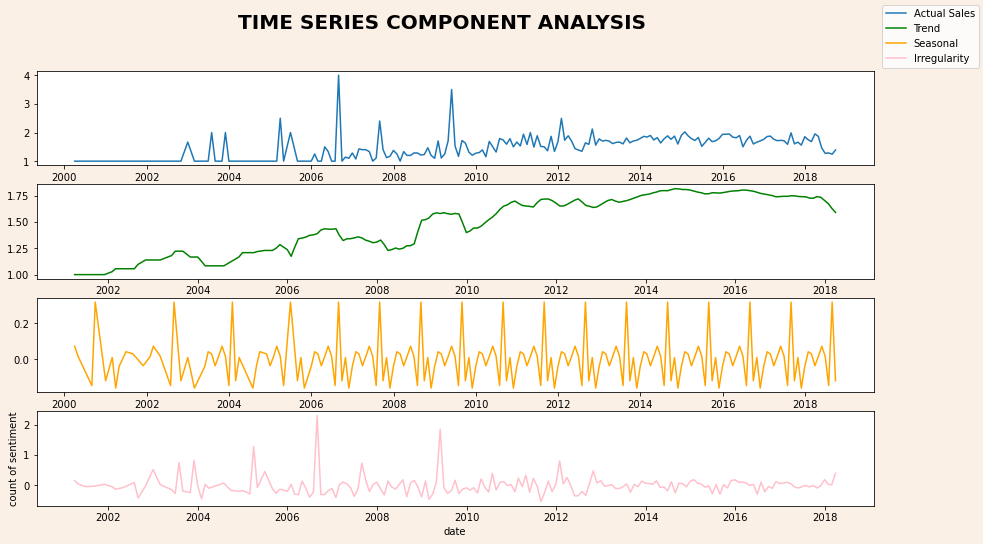

In [ ]:
tsa_comp(office_pos)

In [ ]:
checkStationarity(office_pos)

pvalue: 0.2745359834923668


' Data is not Stationary. Make the data stationary before model building'

In [ ]:
diff_office_pos = office_pos-office_pos.shift(1)
print(diff_office_pos)

            sentiment_count
date                       
2000-03-31              NaN
2000-04-30         0.000000
2000-08-31         0.000000
2000-09-30         0.000000
2000-12-31         0.000000
...                     ...
2018-05-31        -0.410189
2018-06-30        -0.182356
2018-07-31         0.014632
2018-08-31        -0.043578
2018-09-30         0.148061

[197 rows x 1 columns]


In [ ]:
diff_office_pos.dropna(inplace=True)

In [ ]:
checkStationarity(diff_office_pos)

pvalue: 1.0093167722934733e-12


'Data is Stationary. Proceed to model building'

### Splitting

In [ ]:
ratio = 0.7
rows = int(ratio * len(office_pos))
train1 =office_pos[:rows]
test1 = office_pos[rows:]

print("Total={}, Train={}, Test={}".format(len(office_pos), len(train1), len(test1)))

Total=197, Train=137, Test=60


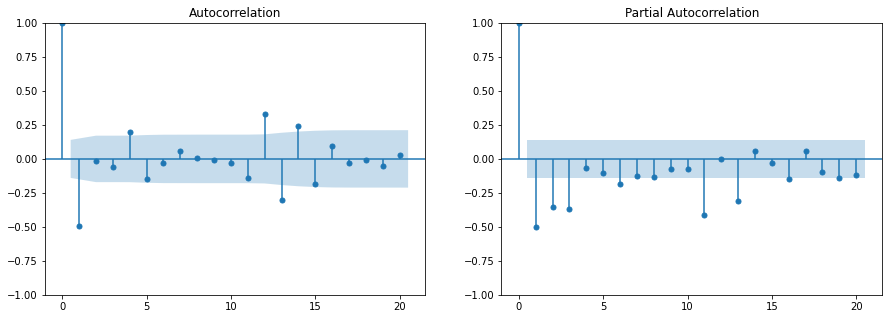

In [ ]:
p_and_q(diff_office_pos)

In [ ]:
d=1;
lis=[]
for p in range(5):
    for q in range(7):
        lis.append((p,d,q))

# building model
model=[]
for i in lis:
    m =ARIMA(train1, order=i).fit() 
    model.append(m)

# checking model is good or not
model_st=[]
c=1
for i in model:
    pvalue = sm.stats.acorr_ljungbox(i.resid, lags=[1], return_df=True)['lb_pvalue'].values
    if pvalue < 0.05:
        print(f'Model {c} Not a good model')
    else:
        print(f'Model {c} Good model')
    c+=1

Model 1 Not a good model
Model 2 Good model
Model 3 Good model
Model 4 Good model
Model 5 Good model
Model 6 Good model
Model 7 Good model
Model 8 Not a good model
Model 9 Good model
Model 10 Good model
Model 11 Good model
Model 12 Good model
Model 13 Good model
Model 14 Good model
Model 15 Good model
Model 16 Good model
Model 17 Good model
Model 18 Good model
Model 19 Good model
Model 20 Good model
Model 21 Good model
Model 22 Good model
Model 23 Good model
Model 24 Good model
Model 25 Good model
Model 26 Good model
Model 27 Good model
Model 28 Good model
Model 29 Good model
Model 30 Good model
Model 31 Good model
Model 32 Good model
Model 33 Good model
Model 34 Good model
Model 35 Good model


In [ ]:
aic=[]
bic=[]
for i in model[0:]:
    aic.append(i.aic)
    bic.append(i.bic)

# predicting values
forecast=[]
for i in model[0:]:
    fcast = i.predict(start=len(train1), end=len(train1)+len(test1)-1)
    forecast.append(fcast)

# calculating MSE and RMSE score
MSE = []
RMSE = []
for i in forecast:
    mse = mean_squared_error(test1, i)
    rmse = np.sqrt(mse)
    MSE.append(mse)
    RMSE.append(rmse)

# printing model numbers
model_no=[]
for i in range(0,len(model)):
    model_no.append('Model '+str(i))
    
# dataframe of all results
df_results1 = pd.DataFrame({'Model No.': model_no, '(p, d, q)':lis[0:], 'AIC': aic, 'BIC': bic, 'MSE': MSE, 'RMSE': RMSE})
df_results1

,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
0,Model 0,"(0, 1, 0)",242.627042,245.539697,0.038323,0.195763
1,Model 1,"(0, 1, 1)",155.156271,160.981581,0.033846,0.183974
2,Model 2,"(0, 1, 2)",156.784841,165.522806,0.033458,0.182915
3,Model 3,"(0, 1, 3)",158.475302,170.125922,0.033247,0.182337
4,Model 4,"(0, 1, 4)",160.379011,174.942285,0.033086,0.181897
5,Model 5,"(0, 1, 5)",159.786343,177.262272,0.034452,0.185612
6,Model 6,"(0, 1, 6)",155.727084,176.115668,0.032273,0.179648
7,Model 7,"(1, 1, 0)",205.723617,211.548927,0.030591,0.174903
8,Model 8,"(1, 1, 1)",156.826525,165.564490,0.033512,0.183063
9,Model 9,"(1, 1, 2)",156.711346,168.361965,0.033731,0.183660


In [ ]:
print('Taking model with lowest RMSE score:')
df_results1[df_results1.RMSE==df_results1.RMSE.min()]


Taking model with lowest RMSE score:


,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
7,Model 7,"(1, 1, 0)",205.723617,211.548927,0.030591,0.174903


In [ ]:
print('Taking model with lowest BIC score:')

df_results1[df_results1.BIC==df_results1.BIC.min()]

Taking model with lowest BIC score:


,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
1,Model 1,"(0, 1, 1)",155.156271,160.981581,0.033846,0.183974


In [ ]:
print('Taking model with lowest AIC score:')
df_results1[df_results1.AIC==df_results1.AIC.min()]

Taking model with lowest AIC score:


,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
33,Model 33,"(4, 1, 5)",150.816171,179.94272,0.033843,0.183965


In [ ]:
p=4;q=5;d=1
P=1;Q=1;D=0
m1 = sm.tsa.statespace.SARIMAX(office_pos['sentiment_count'],order=(p,d,q),seasonal_order=(P,D,Q,12)).fit()
# summarise the model
m1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                      sentiment_count   No. Observations:                  197
Model:             SARIMAX(4, 1, 5)x(1, 0, [1], 12)   Log Likelihood                 -59.673
Date:                              Sun, 22 Jan 2023   AIC                            143.345
Time:                                      10:42:47   BIC                            182.683
Sample:                                           0   HQIC                           159.271
                                              - 197                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2830      0.300     -4.275      0.000      -1.871      -0.695
ar.L2         -1.3777      0.376     -3.666      0.000      -2.114      -0.641
ar.L3         -1.0724      0.329     -3.261      0.001      -1.717      -0.428
ar.L4         -0.6529      0.200     -3.258      0.001      -1.046      -0.260
ma.L1          0.4101      0.288      1.422      0.155      -0.155       0.975
ma.L2          0.1922      0.205      0.938      0.348      -0.209       0.594
ma.L3         -0.2396      0.224     -1.068      0.285      -0.679       0.200
ma.L4         -0.1610      0.191     -0.843      0.399      -0.535       0.213
ma.L5         -0.7496      0.210     -3.574      0.000      -1.161      -0.339
ar.S.L12      -0.1512      0.327     -0.463      0.644      -0.792       0.489
ma.S.L12       0.4349      0.314      1.383      0.167      -0.181       1.051
sigma2         0.1044      0.007     15.883      0.000       0.091       0.117
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):              3380.89
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               0.15   Skew:                             3.38
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# LJung-Box test
pvalue = sm.stats.acorr_ljungbox(m1.resid,lags=[1],return_df=True)['lb_pvalue'].values
if pvalue < 0.05:
    print("Reject H0. Bad model")
else:
    print("Fail-to-Reject H0. Good model")

Fail-to-Reject H0. Good model


In [ ]:
start = len(train1) 
end = len(train1) + len(test1) - 1

print('start = {}, end = {}'.format(start,end))

start = 137, end = 196


In [ ]:
predictions = m1.predict(start,end)
predictions.index=test1.index
print(predictions.head(5))

date
2013-10-31    1.839140
2013-11-30    1.634356
2013-12-31    1.753350
2014-01-31    1.561900
2014-02-28    1.736571
Name: predicted_mean, dtype: float64


In [ ]:
actual = []; pred = []
test1.reset_index(drop=True)
for i in range(len(predictions)):
    actual.append(test1['sentiment_count'][i])
    pred.append(predictions[i])

df_res1 = pd.DataFrame({'actual':actual, 'predicted':pred})
df_res1['error'] = df_res1.actual - df_res1.predicted
df_res1.index=test1.index
print(df_res1.head())

              actual  predicted     error
date                                     
2013-10-31  1.704167   1.839140 -0.134974
2013-11-30  1.731449   1.634356  0.097093
2013-12-31  1.792651   1.753350  0.039301
2014-01-31  1.866477   1.561900  0.304577
2014-02-28  1.840532   1.736571  0.103960


In [ ]:
mse1=mean_squared_error(df_res1.actual,df_res1.predicted)
rmse1=np.sqrt(mse1)
print('mse:',mse1)
print('rmse:',rmse1)

mse: 0.025625330158851958
rmse: 0.16007913717549815


Text(0.5, 1.0, 'SARIMA Model. Order=(4,1,5)')

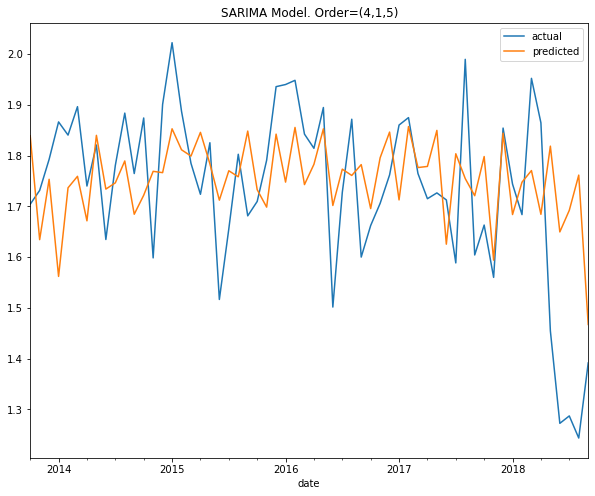

In [ ]:
msg = 'SARIMA Model. Order=(' + str(p) + ',' + str(d) + ',' + str(q) + ')'
df_res1.actual.plot(figsize=(10,8),legend=True)
df_res1.predicted.plot(legend=True)
plt.title(msg)

In [ ]:
future_dates=pd.DataFrame()
future_dates['date']=[     
'2018-10-31',    
'2018-11-30',   
'2018-12-31',    
'2019-01-31',    
'2019-02-28',  
'2019-03-31',   
'2019-04-30',    
'2019-05-31',    
'2019-06-30',  
'2019-07-31',    
'2019-08-31',   
'2019-09-30',  
'2019-10-31',   
'2019-11-30',    
'2019-12-31',    
'2020-01-31',  
'2020-02-29',    
'2020-03-31',   
'2020-04-30',   
'2020-05-31',   
'2020-06-30',   
'2020-07-31',    
'2020-08-31',   
'2020-09-30',  
'2020-10-31',    
'2020-11-30',    
'2020-12-31',    
'2021-01-31',    
'2021-02-28', 
'2021-03-31',    
'2021-04-30',   
'2021-05-31',   
'2021-06-30',
'2021-07-31',
'2021-08-31',
'2021-09-30',
'2021-10-31']      
future_dates=pd.to_datetime(future_dates['date'])
future_dates=pd.DataFrame(future_dates)


In [ ]:
fcast1 = m1.predict(start=len(office_pos),end=len(office_pos)+36).rename('Forecast')
fcast1.index=future_dates.date
print(fcast1.head())

date
2018-10-31    1.664962
2018-11-30    1.549933
2018-12-31    1.634321
2019-01-31    1.675101
2019-02-28    1.522851
Name: Forecast, dtype: float64


<AxesSubplot:xlabel='date', ylabel='count of positive sentiment'>

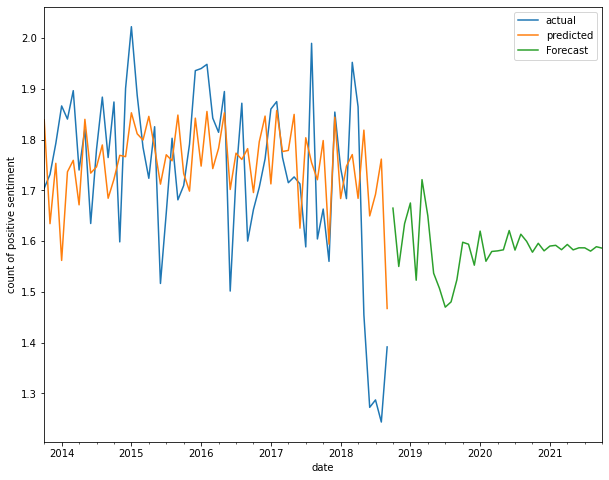

In [ ]:

df_res1.actual.plot(figsize=(10,8),legend=True)
df_res1.predicted.plot(legend=True)
plt.ylabel('count of positive sentiment')
fcast1.plot(legend=True)

### Neutral

In [ ]:
df_office_neu.head(3)

,ratings,verified,date,reviewerID,asin,review,summary,unixReviewTime,category,description,...,word_count,char_count,avg_word,polarity,label,year,rating_class_num,review_length,review_length_bin,Month
367299,3.0,True,2015-09-30,A2Y37RG9KURYR5,B00DXOS27S,runs batteries fast glitches could charge full...,batteries,1443571200,"['Office Products', 'Office Electronics', 'Cal...","[""Texas Instruments TI-84 Plus C Silver Editio...",...,18,118,5.6,0.183333,0.0,2015,1,18,"(0, 100]",9
238147,3.0,True,2011-11-17,A263DRVW6SIFNC,B002FPTJS2,ordered one relatively new printer first prob...,Seems luck of the draw. . .,1321488000,"['Office Products', 'Office & School Supplies'...",['Save even more with our compatible laser ton...,...,64,461,6.4,0.145691,0.0,2011,1,62,"(0, 100]",11
192211,3.0,True,2017-03-18,AYAL8PLI8WM37,B0018RHUM0,writes intended,Three Stars,1489795200,"['Office Products', 'Office & School Supplies'...",['My Store is The goods of High quality and po...,...,2,15,7.0,0.000000,0.0,2017,1,2,"(0, 100]",3


In [ ]:
office_neu_count=df_office_neu.groupby(['asin','Month','Sentiment']).size().reset_index(name='sentiment_count')
office_neu_count

,asin,Month,Sentiment,sentiment_count
0,0310432065,6,Neutral,2
1,0310432065,9,Neutral,2
2,0310802636,10,Neutral,2
3,0310818621,5,Neutral,1
4,0310821800,4,Neutral,1
...,...,...,...,...
19837,B01HFBS7K6,1,Neutral,1
19838,B01HFMQA8G,8,Neutral,1
19839,B01HFW92DG,10,Neutral,4
19840,B01HFW92DG,11,Neutral,2


In [ ]:
office_neu=pd.merge(df_office_neu,office_neu_count)

In [ ]:
office_neu=office_neu[['date','sentiment_count']]
office_neu=office_neu.set_index('date')
office_neu=office_neu.sort_values(by=['date'])
office_neu

,sentiment_count
date,
2000-05-13,1
2000-05-23,2
2000-05-23,2
2000-06-01,2
2000-06-01,2
...,...
2018-09-13,1
2018-09-20,5
2018-09-25,1


In [ ]:
office_neu=office_neu.resample('M').mean()
office_neu.head()

,sentiment_count
date,
2000-05-31,1.666667
2000-06-30,1.666667
2000-07-31,NaN
2000-08-31,NaN
2000-09-30,2.000000


In [ ]:
office_neu.isnull().sum()

sentiment_count    31
dtype: int64

In [ ]:
office_neu.dropna(inplace=True)

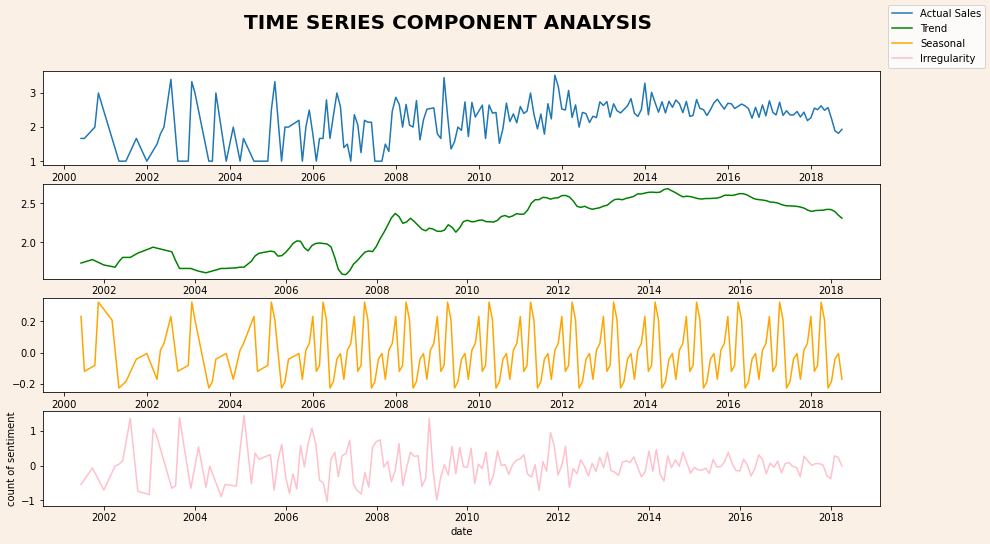

In [ ]:
tsa_comp(office_neu)

In [ ]:
checkStationarity(office_neu)

pvalue: 0.1204672869215313


' Data is not Stationary. Make the data stationary before model building'

In [ ]:
diff_office_neu = office_neu-office_neu.shift(1)
print(diff_office_neu)

            sentiment_count
date                       
2000-05-31              NaN
2000-06-30         0.000000
2000-09-30         0.333333
2000-10-31         1.000000
2001-02-28        -1.333333
...                     ...
2018-05-31         0.079908
2018-06-30        -0.318184
2018-07-31        -0.364335
2018-08-31        -0.071818
2018-09-30         0.115152

[190 rows x 1 columns]


In [ ]:
diff_office_neu.dropna(inplace=True)

In [ ]:
checkStationarity(diff_office_neu)

pvalue: 4.0762493817565416e-10


'Data is Stationary. Proceed to model building'

In [ ]:
ratio = 0.7
rows = int(ratio * len(office_neu))
train2 =office_neu[:rows]
test2 = office_neu[rows:]

print("Total={}, Train={}, Test={}".format(len(office_neu), len(train2), len(test2)))

Total=190, Train=133, Test=57


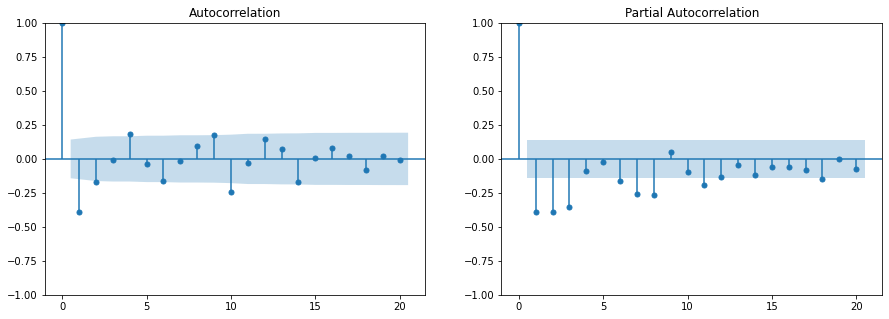

In [ ]:
p_and_q(diff_office_neu)

In [ ]:
d=1;
lis=[]
for p in range(5):
    for q in range(7):
        lis.append((p,d,q))

# building model
model=[]
for i in lis:
    m =ARIMA(train2, order=i).fit() 
    model.append(m)

# checking model is good or not
model_st=[]
c=1
for i in model:
    pvalue = sm.stats.acorr_ljungbox(i.resid, lags=[1], return_df=True)['lb_pvalue'].values
    if pvalue < 0.05:
        print(f'Model {c} Not a good model')
    else:
        print(f'Model {c} Good model')
    c+=1

Model 1 Not a good model
Model 2 Good model
Model 3 Good model
Model 4 Good model
Model 5 Good model
Model 6 Good model
Model 7 Good model
Model 8 Good model
Model 9 Good model
Model 10 Good model
Model 11 Good model
Model 12 Good model
Model 13 Good model
Model 14 Good model
Model 15 Good model
Model 16 Good model
Model 17 Good model
Model 18 Good model
Model 19 Good model
Model 20 Good model
Model 21 Good model
Model 22 Good model
Model 23 Good model
Model 24 Good model
Model 25 Good model
Model 26 Good model
Model 27 Good model
Model 28 Good model
Model 29 Good model
Model 30 Good model
Model 31 Good model
Model 32 Good model
Model 33 Good model
Model 34 Good model
Model 35 Good model


In [ ]:
aic=[]
bic=[]
for i in model[0:]:
    aic.append(i.aic)
    bic.append(i.bic)

# predicting values
forecast=[]
for i in model[0:]:
    fcast = i.predict(start=len(train2), end=len(train2)+len(test2)-1)
    forecast.append(fcast)

# calculating MSE and RMSE score
MSE = []
RMSE = []
for i in forecast:
    mse = mean_squared_error(test2, i)
    rmse = np.sqrt(mse)
    MSE.append(mse)
    RMSE.append(rmse)

# printing model numbers
model_no=[]
for i in range(0,len(model)):
    model_no.append('Model '+str(i))
    
# dataframe of all results
df_results2 = pd.DataFrame({'Model No.': model_no, '(p, d, q)':lis[0:], 'AIC': aic, 'BIC': bic, 'MSE': MSE, 'RMSE': RMSE})
df_results2

,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
0,Model 0,"(0, 1, 0)",316.182577,319.065379,0.679948,0.824590
1,Model 1,"(0, 1, 1)",249.237640,255.003243,0.054615,0.233698
2,Model 2,"(0, 1, 2)",249.897367,258.545773,0.054635,0.233742
3,Model 3,"(0, 1, 3)",250.056086,261.587294,0.056836,0.238403
4,Model 4,"(0, 1, 4)",251.498897,265.912907,0.058330,0.241517
5,Model 5,"(0, 1, 5)",251.671211,268.968022,0.056078,0.236808
6,Model 6,"(0, 1, 6)",251.839285,272.018899,0.057510,0.239813
7,Model 7,"(1, 1, 0)",298.267092,304.032696,0.387350,0.622375
8,Model 8,"(1, 1, 1)",250.289713,258.938119,0.054443,0.233330
9,Model 9,"(1, 1, 2)",251.144977,262.676185,0.055228,0.235007


In [ ]:
print('Taking model with lowest RMSE score:')
df_results2[df_results2.RMSE==df_results2.RMSE.min()]


Taking model with lowest RMSE score:


,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
8,Model 8,"(1, 1, 1)",250.289713,258.938119,0.054443,0.23333


In [ ]:
print('Taking model with lowest BIC score:')

df_results2[df_results2.BIC==df_results2.BIC.min()]

Taking model with lowest BIC score:


,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
1,Model 1,"(0, 1, 1)",249.23764,255.003243,0.054615,0.233698


In [ ]:
print('Taking model with lowest AIC score:')
df_results2[df_results2.AIC==df_results2.AIC.min()]

Taking model with lowest AIC score:


,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
17,Model 17,"(2, 1, 3)",243.068221,260.365033,0.057257,0.239284


In [ ]:
df_results2[(df_results2.AIC==df_results2.AIC.min())|(df_results2.BIC==df_results2.BIC.min())|(df_results2.RMSE==df_results2.RMSE.min())]

,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
1,Model 1,"(0, 1, 1)",249.237640,255.003243,0.054615,0.233698
8,Model 8,"(1, 1, 1)",250.289713,258.938119,0.054443,0.233330
17,Model 17,"(2, 1, 3)",243.068221,260.365033,0.057257,0.239284


In [ ]:
p=2;q=3;d=1
P=1;Q=1;D=1
m2 = sm.tsa.statespace.SARIMAX(office_neu['sentiment_count'],order=(p,d,q),seasonal_order=(P,D,Q,12)).fit()
# summarise the model
m2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                      sentiment_count   No. Observations:                  190
Model:             SARIMAX(2, 1, 3)x(1, 1, [1], 12)   Log Likelihood                -143.141
Date:                              Sun, 22 Jan 2023   AIC                            302.281
Time:                                      10:53:13   BIC                            327.691
Sample:                                           0   HQIC                           312.586
                                              - 190                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4623      1.734     -0.267      0.790      -3.860       2.936
ar.L2          0.4376      1.597      0.274      0.784      -2.693       3.569
ma.L1         -0.3818      2.207     -0.173      0.863      -4.708       3.944
ma.L2         -0.9691      1.713     -0.566      0.572      -4.327       2.389
ma.L3          0.4104      1.697      0.242      0.809      -2.916       3.737
ar.S.L12       0.0199      0.095      0.210      0.833      -0.165       0.205
ma.S.L12      -0.7990      0.135     -5.937      0.000      -1.063      -0.535
sigma2         0.2629      0.311      0.845      0.398      -0.347       0.873
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                 5.22
Prob(Q):                              0.71   Prob(JB):                         0.07
Heteroskedasticity (H):               0.14   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# LJung-Box test
pvalue = sm.stats.acorr_ljungbox(m2.resid,lags=[1],return_df=True)['lb_pvalue'].values
if pvalue < 0.05:
    print("Reject H0. Bad model")
else:
    print("Fail-to-Reject H0. Good model")

Fail-to-Reject H0. Good model


In [ ]:
start = len(train2) 
end = len(train2) + len(test2) - 1

print('start = {}, end = {}'.format(start,end))

start = 133, end = 189


In [ ]:
predictions = m2.predict(start,end)
predictions.index=test2.index
print(predictions.head())

date
2014-01-31    2.701458
2014-02-28    2.554520
2014-03-31    3.077425
2014-04-30    2.669681
2014-05-31    2.401753
Name: predicted_mean, dtype: float64


In [ ]:
actual = []; pred = []
test2.reset_index(drop=True)
for i in range(len(predictions)):
    actual.append(test2['sentiment_count'][i])
    pred.append(predictions[i])

df_res2 = pd.DataFrame({'actual':actual, 'predicted':pred})
df_res2['error'] = df_res2.actual - df_res2.predicted
df_res2.index=test2.index
print(df_res2.head())

              actual  predicted     error
date                                     
2014-01-31  2.358166   2.701458 -0.343291
2014-02-28  3.020888   2.554520  0.466368
2014-03-31  2.716381   3.077425 -0.361044
2014-04-30  2.438356   2.669681 -0.231325
2014-05-31  2.743017   2.401753  0.341264


In [ ]:
mse2=mean_squared_error(df_res2.actual,df_res2.predicted)
rmse2=np.sqrt(mse2)
print('mse:',mse2)
print('rmse:',rmse2)

mse: 0.06483322445959665
rmse: 0.25462369186624534


Text(0.5, 1.0, 'SARIMA Model. Order=(2,1,3)')

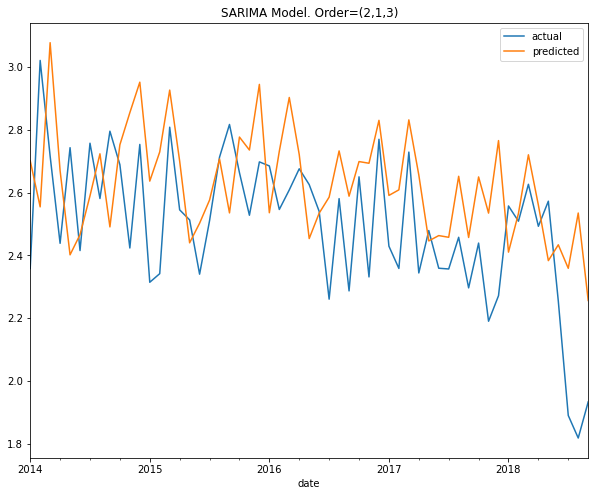

In [ ]:
msg = 'SARIMA Model. Order=(' + str(p) + ',' + str(d) + ',' + str(q) + ')'
df_res2.actual.plot(figsize=(10,8),legend=True)
df_res2.predicted.plot(legend=True)
plt.title(msg)

In [ ]:
fcast2 = m2.predict(start=len(office_neu),end=len(office_neu)+36).rename('Forecast')
fcast2.index=future_dates.date
print(fcast2)

date
2018-10-31    2.495778
2018-11-30    2.339591
2018-12-31    2.604020
2019-01-31    2.388161
2019-02-28    2.460459
2019-03-31    2.632841
2019-04-30    2.486911
2019-05-31    2.363863
2019-06-30    2.308485
2019-07-31    2.210859
2019-08-31    2.353569
2019-09-30    2.227930
2019-10-31    2.511274
2019-11-30    2.367789
2019-12-31    2.610140
2020-01-31    2.400943
2020-02-29    2.456696
2020-03-31    2.646211
2020-04-30    2.484331
2020-05-31    2.371528
2020-06-30    2.307901
2020-07-31    2.228059
2020-08-31    2.363369
2020-09-30    2.243796
2020-10-31    2.511465
2020-11-30    2.377663
2020-12-31    2.610785
2021-01-31    2.409911
2021-02-28    2.457702
2021-03-31    2.654670
2021-04-30    2.485844
2021-05-31    2.379423
2021-06-30    2.309875
2021-07-31    2.235751
2021-08-31    2.365915
2021-09-30    2.251121
2021-10-31    2.514137
Name: Forecast, dtype: float64


<AxesSubplot:xlabel='date', ylabel='count of neutral sentiment'>

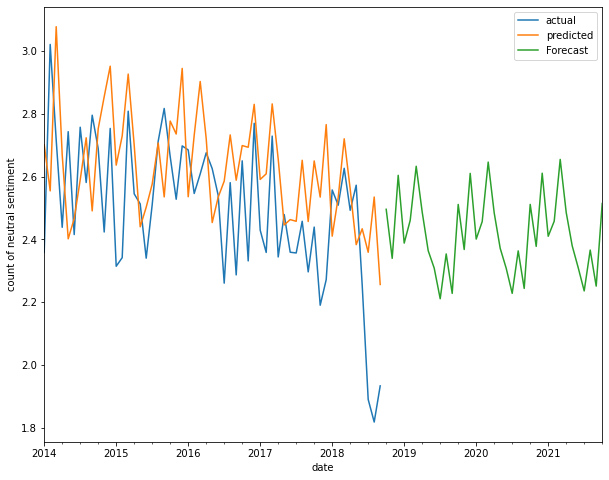

In [ ]:
plt.ylabel('count of neutral sentiment')
df_res2.actual.plot(figsize=(10,8),legend=True)
df_res2.predicted.plot(legend=True)
fcast2.plot(legend=True)

### Negative

In [ ]:
office_neg_count=df_office_neg.groupby(['asin','Month','Sentiment']).size().reset_index(name='sentiment_count')
office_neg_count

,asin,Month,Sentiment,sentiment_count
0,0310823706,4,Negative,1
1,0312385331,12,Negative,1
2,0439499887,9,Negative,2
3,0439505399,3,Negative,1
4,0439731771,7,Negative,1
...,...,...,...,...
20494,B01HFW92DG,3,Negative,1
20495,B01HFW92DG,12,Negative,2
20496,B01HGG9P10,6,Negative,3
20497,B01HH8E2QA,7,Negative,2


In [ ]:
office_neg=pd.merge(df_office_neg,office_neg_count)

In [ ]:
office_neg=office_neg[['date','sentiment_count']]
office_neg=office_neg.set_index('date')
office_neg=office_neg.sort_values(by=['date'])
office_neg

,sentiment_count
date,
2000-03-18,2
2000-03-18,2
2000-04-08,3
2000-04-08,3
2000-04-08,3
...,...
2018-09-19,3
2018-09-19,1
2018-09-19,3


In [ ]:
office_neg=office_neg.resample('M').mean()
office_neg.head()

,sentiment_count
date,
2000-03-31,2.000000
2000-04-30,3.000000
2000-05-31,1.666667
2000-06-30,NaN
2000-07-31,NaN


In [ ]:
office_neg.isnull().sum()

sentiment_count    27
dtype: int64

In [ ]:
office_neg.dropna(inplace=True)

In [ ]:
checkStationarity(office_neg)

pvalue: 0.278698691206986


' Data is not Stationary. Make the data stationary before model building'

In [ ]:
diff_office_neg = office_neg-office_neg.shift(1)
print(diff_office_neg)

            sentiment_count
date                       
2000-03-31              NaN
2000-04-30         1.000000
2000-05-31        -1.333333
2001-02-28        -0.666667
2001-06-30         0.000000
...                     ...
2018-05-31        -0.198345
2018-06-30        -0.193348
2018-07-31         0.208360
2018-08-31        -0.041111
2018-09-30        -0.089892

[196 rows x 1 columns]


In [ ]:
diff_office_neg.dropna(inplace=True)

In [ ]:
checkStationarity(diff_office_neg)

pvalue: 1.8689492339249041e-13


'Data is Stationary. Proceed to model building'

In [ ]:
ratio = 0.7
rows = int(ratio * len(office_neg))
train3 =office_neg[:rows]
test3 = office_neg[rows:]

print("Total={}, Train={}, Test={}".format(len(office_neg), len(train3), len(test3)))

Total=196, Train=137, Test=59


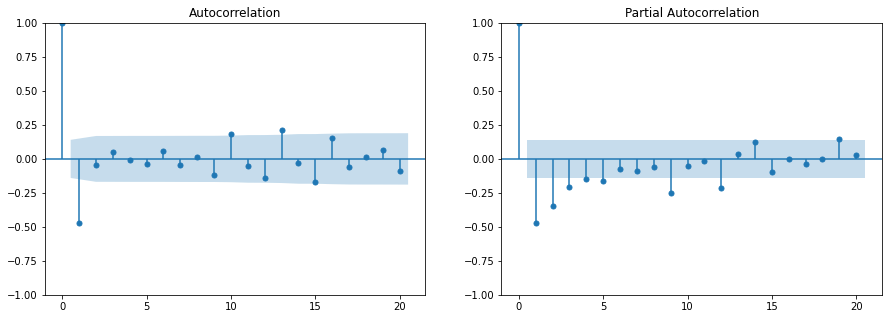

In [ ]:
p_and_q(diff_office_neg)

In [ ]:
d=1;
lis=[]
for p in range(6):
    for q in range(5):
        lis.append((p,d,q))

# building model
model=[]
for i in lis:
    m =ARIMA(train3, order=i).fit() 
    model.append(m)

# checking model is good or not
model_st=[]
c=1
for i in model:
    pvalue = sm.stats.acorr_ljungbox(i.resid, lags=[1], return_df=True)['lb_pvalue'].values
    if pvalue < 0.05:
        print(f'Model {c} Not a good model')
    else:
        print(f'Model {c} Good model')
    c+=1

Model 1 Not a good model
Model 2 Good model
Model 3 Good model
Model 4 Good model
Model 5 Good model
Model 6 Good model
Model 7 Good model
Model 8 Good model
Model 9 Good model
Model 10 Good model
Model 11 Good model
Model 12 Good model
Model 13 Good model
Model 14 Good model
Model 15 Good model
Model 16 Good model
Model 17 Good model
Model 18 Good model
Model 19 Good model
Model 20 Good model
Model 21 Good model
Model 22 Good model
Model 23 Good model
Model 24 Good model
Model 25 Good model
Model 26 Good model
Model 27 Good model
Model 28 Good model
Model 29 Good model
Model 30 Good model


In [ ]:
aic=[]
bic=[]
for i in model[0:]:
    aic.append(i.aic)
    bic.append(i.bic)

# predicting values
forecast=[]
for i in model[0:]:
    fcast = i.predict(start=len(train3), end=len(train3)+len(test3)-1)
    forecast.append(fcast)

# calculating MSE and RMSE score
MSE = []
RMSE = []
for i in forecast:
    mse = mean_squared_error(test3, i)
    rmse = np.sqrt(mse)
    MSE.append(mse)
    RMSE.append(rmse)

# printing model numbers
model_no=[]
for i in range(0,len(model)):
    model_no.append('Model '+str(i))
    
# dataframe of all results
df_results3 = pd.DataFrame({'Model No.': model_no, '(p, d, q)':lis[0:], 'AIC': aic, 'BIC': bic, 'MSE': MSE, 'RMSE': RMSE})
df_results3

,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
0,Model 0,"(0, 1, 0)",238.638432,241.551087,0.044734,0.211504
1,Model 1,"(0, 1, 1)",167.439587,173.264897,0.047441,0.217809
2,Model 2,"(0, 1, 2)",169.378428,178.116392,0.047404,0.217725
3,Model 3,"(0, 1, 3)",171.124084,182.774704,0.047467,0.217870
4,Model 4,"(0, 1, 4)",173.069239,187.632513,0.047567,0.218098
5,Model 5,"(1, 1, 0)",204.420368,210.245678,0.045551,0.213428
6,Model 6,"(1, 1, 1)",169.383603,178.121568,0.047407,0.217731
7,Model 7,"(1, 1, 2)",171.271649,182.922268,0.047402,0.217719
8,Model 8,"(1, 1, 3)",167.114424,181.677699,0.161300,0.401621
9,Model 9,"(1, 1, 4)",172.922051,190.397980,0.046859,0.216469


In [ ]:
print('Taking model with lowest RMSE score:')
df_results3[df_results3.RMSE==df_results3.RMSE.min()]


Taking model with lowest RMSE score:


,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
0,Model 0,"(0, 1, 0)",238.638432,241.551087,0.044734,0.211504


In [ ]:
print('Taking model with lowest BIC score:')

df_results3[df_results3.BIC==df_results3.BIC.min()]

Taking model with lowest BIC score:


,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
1,Model 1,"(0, 1, 1)",167.439587,173.264897,0.047441,0.217809


In [ ]:
print('Taking model with lowest AIC score:')
df_results3[df_results3.AIC==df_results3.AIC.min()]

Taking model with lowest AIC score:


,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
12,Model 12,"(2, 1, 2)",166.186187,180.749461,0.160858,0.401071


In [ ]:
p=2;q=2;d=1
P=1;Q=1;D=1
m3 = sm.tsa.statespace.SARIMAX(office_neg['sentiment_count'],order=(p,d,q),seasonal_order=(P,D,Q,12)).fit()
# summarise the model
m3.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                      sentiment_count   No. Observations:                  196
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood                 -98.204
Date:                              Sun, 22 Jan 2023   AIC                            210.407
Time:                                      10:57:35   BIC                            232.874
Sample:                                           0   HQIC                           219.514
                                              - 196                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5088      0.531     -0.958      0.338      -1.550       0.533
ar.L2         -0.0341      0.118     -0.290      0.772      -0.265       0.196
ma.L1         -0.3062      0.520     -0.588      0.556      -1.326       0.714
ma.L2         -0.5215      0.470     -1.109      0.268      -1.444       0.400
ar.S.L12      -0.1344      0.094     -1.434      0.152      -0.318       0.049
ma.S.L12      -0.7758      0.105     -7.399      0.000      -0.981      -0.570
sigma2         0.1572      0.013     12.271      0.000       0.132       0.182
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               178.54
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               0.15   Skew:                             0.87
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# LJung-Box test
pvalue = sm.stats.acorr_ljungbox(m3.resid,lags=[1],return_df=True)['lb_pvalue'].values
if pvalue < 0.05:
    print("Reject H0. Bad model")
else:
    print("Fail-to-Reject H0. Good model")

Fail-to-Reject H0. Good model


In [ ]:
start = len(train3) 
end = len(train3) + len(test3) - 1

print('start = {}, end = {}'.format(start,end))

start = 137, end = 195


In [ ]:
predictions = m3.predict(start,end)
predictions.index=test3.index
print(predictions.head())

date
2013-11-30    2.797912
2013-12-31    2.542814
2014-01-31    2.623581
2014-02-28    2.414891
2014-03-31    2.470970
Name: predicted_mean, dtype: float64


In [ ]:
actual = []; pred = []
test3.reset_index(drop=True)
for i in range(len(predictions)):
    actual.append(test3['sentiment_count'][i])
    pred.append(predictions[i])

df_res3 = pd.DataFrame({'actual':actual, 'predicted':pred})
df_res3['error'] = df_res3.actual - df_res3.predicted
df_res3.index=test3.index
print(df_res3.head())

              actual  predicted     error
date                                     
2013-11-30  2.818182   2.797912  0.020270
2013-12-31  2.450549   2.542814 -0.092264
2014-01-31  2.610465   2.623581 -0.013116
2014-02-28  2.585366   2.414891  0.170475
2014-03-31  2.537500   2.470970  0.066530


In [ ]:
mse3=mean_squared_error(df_res3.actual,df_res3.predicted)
rmse3=np.sqrt(mse3)
print('mse:',mse3)
print('rmse:',rmse3)

mse: 0.04943881217964915
rmse: 0.2223484026919221


Text(0.5, 1.0, 'SARIMA Model. Order=(2,1,2)')

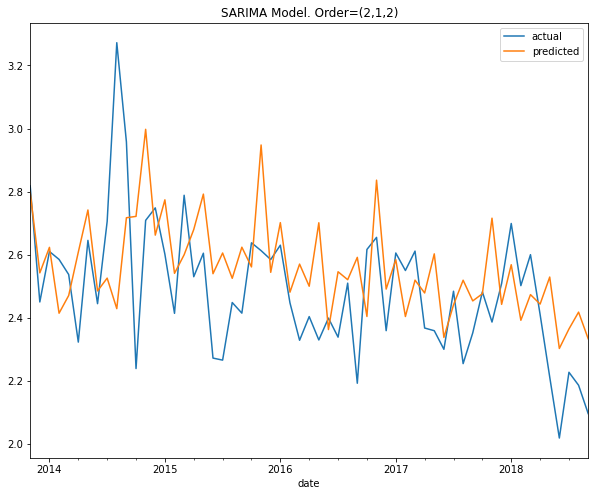

In [ ]:
msg = 'SARIMA Model. Order=(' + str(p) + ',' + str(d) + ',' + str(q) + ')'
df_res3.actual.plot(figsize=(10,8),legend=True)
df_res3.predicted.plot(legend=True)
plt.title(msg)

In [ ]:
fcast3 = m3.predict(start=len(office_neg),end=len(office_neg)+36).rename('Forecast')
fcast3.index=future_dates.date
print(fcast3.head())

date
2018-10-31    2.386463
2018-11-30    2.591510
2018-12-31    2.382521
2019-01-31    2.491707
2019-02-28    2.340842
Name: Forecast, dtype: float64


<AxesSubplot:xlabel='date', ylabel='count of negative sentiment'>

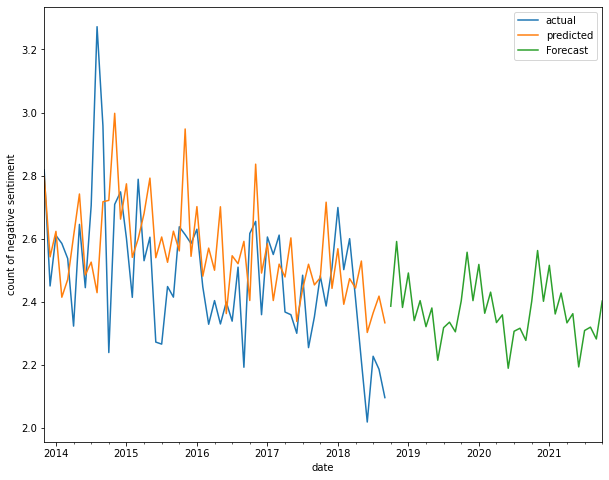

In [ ]:
df_res3.actual.plot(figsize=(10,8),legend=True)
df_res3.predicted.plot(legend=True)
plt.ylabel('count of negative sentiment')
fcast3.plot(legend=True)
